In [1]:
import datasets
import os
import openai

/Users/federico.cassano/.pyenv/versions/3.9.19/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
client = openai.Client(api_key=os.environ["OPENAI_API_KEY"])

KeyError: 'OPENAI_API_KEY'

In [33]:
ds = datasets.load_dataset("codegenning/orm_dataset_raw50_og", split="train")
ds = ds.shuffle()
ds

Dataset({
    features: ['unique_name', 'prompt', 'starter_code', 'difficulty', 'results'],
    num_rows: 13402
})

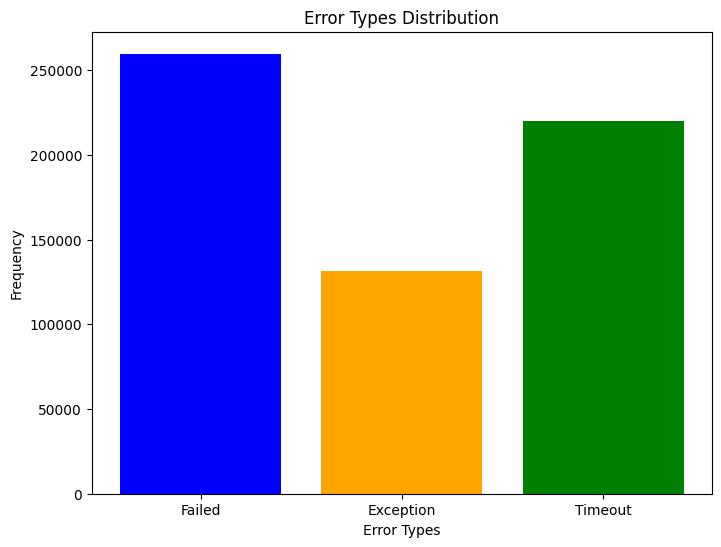

In [34]:
import matplotlib.pyplot as plt
from codeprm.eval.redo_code_execution import get_err_kind
    
errs = [] # err types: "Timeout", "Exception", "Failed Tests"
timeout_exs = []
at_least_one_passing = []
for ex in ds:
    passing = None
    for r in ex["results"]:
        if not r["passing"]:
            kind = get_err_kind(r)
            errs.append(kind)
            if kind == "Timeout":
                timeout_exs.append((ex, r["code"], r["output"]))
        else:
            passing = r["code"]
        
    if passing != None:
        at_least_one_passing.append((ex, passing))

error_counts = {error: errs.count(error) for error in set(errs)}

error_types = list(error_counts.keys())
counts = list(error_counts.values())

plt.figure(figsize=(8, 6))
plt.bar(error_types, counts, color=['blue', 'orange', 'green'])
plt.xlabel('Error Types')
plt.ylabel('Frequency')
plt.title('Error Types Distribution')
plt.show()

# GPT-4 agreement

In [ ]:
from codeprm.prompts import py_prompt
import random
random.seed(42)
check_size = 5000
samples = []
for ex in ds.select(range(check_size)):
    r = random.choice(ex["results"])
    code = r["code"]
    code = ex["starter_code"] + code
    code = py_prompt(ex["prompt"], code)
    r["code"] = code
    samples.append(r)
print(samples[100]["code"])

In [62]:
from tqdm import tqdm
code = samples[0]["code"]
def gpt_classifier(code, model="gpt-4o"):
    system = "You are a champion competitive programmer. You are able to identify if an algorithmic solution to a problem is either correct or not. You will respond only with Yes or No, then, only after the Yes/No, you will provide a very brief explaination of why."
    resp = client.chat.completions.create(
        model=model,
        temperature=0.0,
        messages=[
            {
                "role": "system",
                "content": system,
            },
            {
                "role": "user",
                "content": f"Please respond with Yes or No if the given program is correct or not, then after the newline, very briefly explain why:\n{code}",
            }
        ]
    )
    split = resp.choices[0].message.content.split("\n")
    if len(split) < 2:
        return None
    split = [s for s in split if s.strip() != ""]
    cls = split[0].strip()
    exp = "\n".join(split[1:])
    if cls != "Yes" and cls != "No":
        return None
    if cls == "Yes":
        cls_b = True
    elif cls == "No":
        cls_b = False
    return cls_b, exp

new_ds = datasets.Dataset.from_list(samples)
cls = [None] * len(samples)
exp = [None] * len(samples)
new_ds = new_ds.add_column("cls", cls)
new_ds = new_ds.add_column("exp", exp)

def run_cls(ex):
    code = ex["code"]
    out = gpt_classifier(code)
    if out is not None:
        cls, exp = out
        return {"cls": cls, "exp": exp}

new_ds = new_ds.map(run_cls, num_proc=96)

Map (num_proc=96): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:39<00:00, 50.06 examples/s]


In [64]:
bad_cls = 0
agreement = 0
disagrees_on_passing = 0
disagrees_on_failing = 0
disagrees = []
for ex in new_ds:
    cls = ex["cls"]
    p = ex["passing"]
    
    if cls is None:
        bad_cls += 1
        continue
        
    if cls == p:
        agreement += 1
    else:
        if p:
            disagrees_on_passing += 1
        else:
            disagrees_on_failing += 1
        disagrees.append(ex)

print(f"Agreement rate: {agreement / len(new_ds)}")
print(f"Disagrees on tests passing: {disagrees_on_passing / len(disagrees)}")
print(f"Disagrees on tests failing: {disagrees_on_failing / len(disagrees)}")

Agreement rate: 0.9066
Disagrees on tests passing: 0.7387580299785867
Disagrees on tests failing: 0.26124197002141325


# Timeout analysis

In [36]:
import datasets
ds = datasets.load_dataset("cassanof/taco_cleaned_all", split="train")

In [39]:
print(len(timeout_exs))

219700


In [38]:
import json
from codeprm.execution import smart_exec_tests_queuebatched
i = 700
ex, code, o = timeout_exs[i]
q = ex["prompt"]
orig_ex = ds.filter(lambda ex: ex["question"] == q)[0]
tests = json.loads(orig_ex["input_output"])
limit = orig_ex["time_limit"]
print(f"Time Limit: {limit}")
print(f"Output: {o}")
# print(tests)
print(code)
smart_exec_tests_queuebatched([code], [tests])

Filter: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13402/13402 [00:02<00:00, 5457.39 examples/s]


Time Limit: None
Output: errored with 'Timeout'



# Read the number of friends
n = int(input())
# Initialize an empty list to store the edges and their costs
edge = []
# Initialize an empty list to store the visited nodes
vis = []
# Initialize an empty list to store the parent nodes
fa = []
# Read the edges and their costs
for i in range(n - 1):
    edge.append(list(map(int, input().split())))
# Initialize the visited nodes list with False values
for i in range(n):
    vis.append(False)
# Initialize the parent nodes list with -1 values
for i in range(n):
    fa.append(-1)
# Initialize the starting node as 0
start = 0
# Initialize the depth of the starting node as 0
deep = 0
# Mark the starting node as visited
vis[start] = True
# Initialize an empty list to store the depth of each node
deep_node = []
# Initialize an empty list to store the cost of each node
deep_cost = []
# Initialize an empty list to store the children of each node
son = []
# Initialize an empty list to store the cost

Executing tests: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.01it/s]


[(False,
  'errored with \'Traceback (most recent call last):\\n  File "/tmp/codeexec/16.py", line 115, in <module>\\n    __run_prog__()\\n  File "/tmp/codeexec/16.py", line 109, in __run_prog__\\n    print(max_cost)\\nUnboundLocalError: local variable \\\'max_cost\\\' referenced before assignment\\n\'\n')]

In [42]:
ds = datasets.load_dataset("codegenning/orm_dataset_raw50", split="train")
ds

Dataset({
    features: ['content', 'score', 'solution'],
    num_rows: 76338
})